In [124]:
import pandas as pd
import numpy as np

# 读取数据（注意：文件必须与 notebook 在同一文件夹）
df = pd.read_csv("im_ex_port.csv")

# 排序 & 构造日期索引
df = df.sort_values(["Year", "Month"]).reset_index(drop=True)
df["Date"] = pd.to_datetime(
    df["Year"].astype(int).astype(str) + "-" + df["Month"].astype(int).astype(str) + "-01"
)
# print(len(df['Date'].unique()) == len(df))  # 确认日期唯一
df = df.set_index("Date")

df.head()


,Year,Month,Import Value,Export Value,General Import Charges,FEDFUNDS,World_import_level,MANEMP
Date,,,,,,,,
2008-01-01,2008,1,1.720000e+11,2.150991e+10,141976383,3.94,89.7,13717
2008-02-01,2008,2,1.710000e+11,2.080000e+11,208876204,2.98,89.6,13690
2008-03-01,2008,3,1.750000e+11,1.580863e+10,27486935,2.61,89.2,13650
2008-04-01,2008,4,1.870000e+11,3.540540e+09,4609632317,2.28,89.5,13589
2008-05-01,2008,5,1.880000e+11,2.100000e+11,10090640522,1.98,88.3,13555


<Axes: xlabel='Date'>

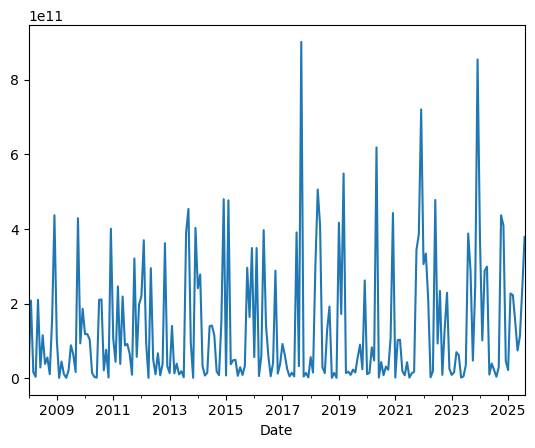

In [125]:
df['Export Value'].plot()

<Axes: xlabel='Date'>

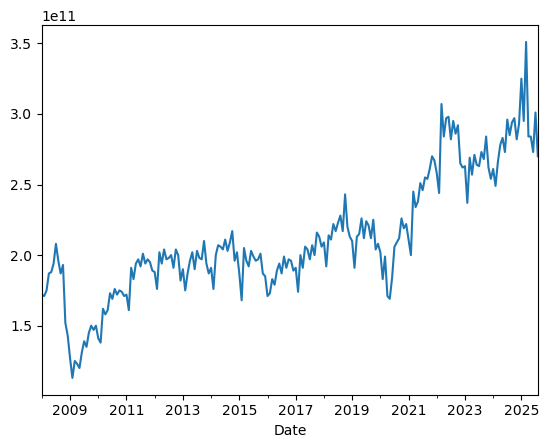

In [126]:
df['Import Value'].plot()

In [ ]:
# 基于季节性平滑化 export value
df['Export Value_log'] = np.log1p(df['Export Value'])
# 2. 简单移动平均 (window 可调) —— 去除短期噪声
df['Export_Value_MA3']  = df['Export Value_log'].rolling(window=3, min_periods=1).mean()
df['Export_Value_MA12'] = df['Export Value_log'].rolling(window=12, min_periods=1).mean()

# 3. 指数加权滑动 (EWMA) —— 更快响应近期变化
df['Export_Value_EWMA_alpha0.3'] = df['Export Value_log'].ewm(alpha=0.3, adjust=False).mean()

# 4. STL 分解季节调整 (需要 statsmodels>=0.13)
try:
    from statsmodels.tsa.seasonal import STL
    stl_res = STL(df['Export Value_log'], period=12, robust=True).fit()
    df['Export_Value_STL_trend']   = stl_res.trend
    df['Export_Value_STL_season']  = stl_res.seasonal
    df['Export_Value_STL_resid']   = stl_res.resid
    # 季节调整序列（去掉季节分量）
    df['Export_Value_STL_adj']     = df['Export Value_log'] - stl_res.seasonal
except Exception as e:
    print("STL 分解失败:", e)

# 5. Hodrick-Prescott (HP) 滤波提取长期趋势 (lambda 对月度常用 129600 或 14400)
try:
    from statsmodels.tsa.filters.hp_filter import hpfilter
    trend, cycle = hpfilter(df['Export Value_log'], lamb=14400)
    df['Export_Value_HP_trend'] = trend
    df['Export_Value_HP_cycle'] = cycle
except Exception as e:
    print("HP 滤波失败:", e)

# 6. Rolling 中位数 + IQR 异常值 Winsor（可选）
col = 'Export Value_log'
q1, q3 = df[col].quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
df['Export_Value_winsor'] = df[col].clip(lower, upper)
df['Export_Value_winsor_MA3'] = df['Export_Value_winsor'].rolling(3, min_periods=1).mean()
ss
# === 修正 LOESS 平滑 ===
try:
    from statsmodels.nonparametric.smoothers_lowess import lowess
    y_log = df['Export Value_log'].values
    # 使用相对时间序列号避免绝对时间尺度过大导致数值问题
    x_num = np.arange(len(df))  # 或: (df.index.view('int64') // 10**9) 转为秒
    # 可调 frac（窗口比例），建议 0.10~0.25；it 为迭代次数（稳健性）
    df['Export_Value_LOESS'] = lowess(y_log, x_num, frac=0.15, it=3, return_sorted=False)
except Exception as e:
    print("LOESS 平滑仍失败:", e)

# 若需要只在历史（不窥视未来）下生成“因果”LOESS，可改为递增窗口的滚动回归：
def incremental_loess(series, frac=0.15):ssss
    from statsmodels.nonparametric.smoothers_lowess import lowess
    out = np.empty_like(series)
    n = len(series)
    win = max(5, int(frac * n))  # 初始最小窗口
    for i in range(n):
        # 当前使用 0..i 的数据拟合再取最后一个点
        sub_y = series[:i+1]
        sub_x = np.arange(i+1)
        local_frac = min(0.9, frac)  # 防止过大
        fitted = lowess(sub_y, sub_x, frac=local_frac, it=1, return_sorted=False)
        out[i] = fitted[-1]
    return out

# 可选：生成因果版（如需避免未来信息泄漏）
# df['Export_Value_LOESS_causal'] = incremental_loess(df['Export Value_log'].values, frac=0.15)

# 最终供模型使用的平滑列（优先季调 STL，其次 LOESS，再回退 EWMA）
df['Export_Value_for_model'] = (
    df.get('Export_Value_STL_adj')
      .fillna(df.get('Export_Value_LOESS'))
      .fillna(df.get('Export_Value_EWMA_alpha0.3'))
)

print("平滑列更新完成：", [c for c in df.columns if c.startswith('Export_Value_')][:10])
df[['Export Value_log','Export_Value_STL_adj','Export_Value_LOESS','Export_Value_for_model']].head()

平滑列更新完成： ['Export_Value_MA3', 'Export_Value_MA12', 'Export_Value_EWMA_alpha0.3', 'Export_Value_STL_trend', 'Export_Value_STL_season', 'Export_Value_STL_resid', 'Export_Value_STL_adj', 'Export_Value_HP_trend', 'Export_Value_HP_cycle', 'Export_Value_winsor']


,Export Value_log,Export_Value_STL_adj,Export_Value_LOESS,Export_Value_for_model
Date,,,,
2008-01-01,23.791780,23.970136,24.375270,23.970136
2008-02-01,26.060804,24.748999,24.382323,24.748999
2008-03-01,23.483822,24.244865,24.389423,24.244865
2008-04-01,21.987545,24.469893,24.396551,24.469893
2008-05-01,26.070373,24.578839,24.403854,24.578839


<Axes: xlabel='Date'>

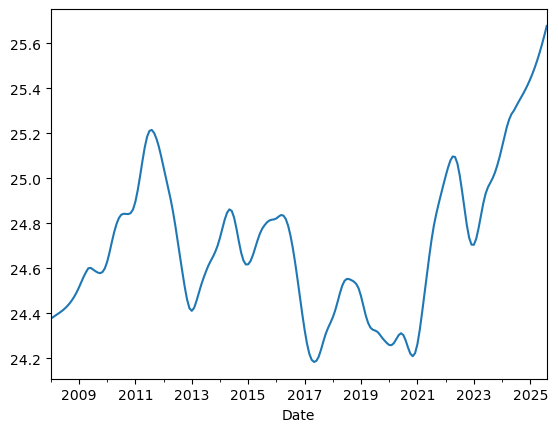

In [128]:
df['Export_Value_LOESS'].plot()

In [129]:
# === 构造经济变量 ===

# 总贸易量
df["TradeVolume"] = df["Import Value"] + df["Export Value"]

# 一阶差分
df["ΔImport"] = df["Import Value"].diff()
df["ΔExport"] = df["Export_Value_LOESS"].diff()
df["ΔTariff"] = df["General Import Charges"].diff()

eps = 1e-5  # 避免除以0

# (1) 关税强度 proxy
df["z1"] = np.log1p(df["ΔTariff"] / (df["Import Value"] + eps))

# (2) 贸易结构变化
df["z2"] = (df["ΔImport"] / (df["Import Value"] + eps)) + (df["ΔExport"] / (df["Export_Value_LOESS"] + eps))
df['z2'] = 1/ (1+np.exp(-df['z2']))

# (3) 利率
df["z3"] = df["FEDFUNDS"]

# (4) 全球贸易规模
df["z4"] = np.log(df["TradeVolume"] + eps)

# (5) 制造业变化（差分 log）
df["z5"] = np.log(df["MANEMP"] + eps).diff()

# (6) 世界进口景气度
df["z6"] = df["World_import_level"]

# 因变量：进口的 log 差分
df["y_level"] = np.log(df["Import Value"] + eps)
df["dy"] = df["y_level"].diff()

df[["dy","z1","z2","z3","z4","z5","z6"]].head(10)


,dy,z1,z2,z3,z4,z5,z6
Date,,,,,,,
2008-01-01,NaN,NaN,NaN,3.94,25.988595,NaN,89.7
2008-02-01,-0.005831,0.000391,0.498610,2.98,26.660802,-0.001970,89.6
2008-03-01,0.023122,-0.001037,0.505787,2.61,25.974537,-0.002926,89.2
2008-04-01,0.066323,0.024208,0.516110,2.28,25.973131,-0.004479,89.5
2008-05-01,0.005333,0.028737,0.501405,1.98,26.709718,-0.002505,88.3
2008-06-01,0.031416,-0.028524,0.507812,2.00,26.128899,-0.004510,88.2
2008-07-01,0.069680,-0.007811,0.516912,2.01,26.500918,-0.005574,87.9
2008-08-01,-0.059423,0.030644,0.484804,2.00,26.178426,-0.005305,87.2
2008-09-01,-0.047006,0.076360,0.488093,1.81,26.212910,-0.006087,86.3


====== 基础结构信息 ======
数据形状: (212, 34)
列名列表: ['Year', 'Month', 'Import Value', 'Export Value', 'General Import Charges', 'FEDFUNDS', 'World_import_level', 'MANEMP', 'Export Value_log', 'Export_Value_MA3', 'Export_Value_MA12', 'Export_Value_EWMA_alpha0.3', 'Export_Value_STL_trend', 'Export_Value_STL_season', 'Export_Value_STL_resid', 'Export_Value_STL_adj', 'Export_Value_HP_trend', 'Export_Value_HP_cycle', 'Export_Value_winsor', 'Export_Value_winsor_MA3', 'Export_Value_LOESS', 'Export_Value_for_model', 'TradeVolume', 'ΔImport', 'ΔExport', 'ΔTariff', 'z1', 'z2', 'z3', 'z4', 'z5', 'z6', 'y_level', 'dy']

====== 缺失值统计 (仅显示有缺失的列) ======
ΔImport    1
ΔExport    1
ΔTariff    1
z1         1
z2         1
z5         1
dy         1
dtype: int64

====== 日期索引检查 ======
索引类型: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
是否单调递增: True
是否唯一: True
预计月度总期数: 212 实际期数: 212
缺失月份数量: 0
重复日期数量: 0

====== 关键经济变量描述统计 ======
                        count          mean           std           min  \
Import V

C:\Users\18765\AppData\Local\Temp\ipykernel_55144\1569529673.py:88: UserWarning: Glyph 21464 (\N{CJK UNIFIED IDEOGRAPH-53D8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\18765\AppData\Local\Temp\ipykernel_55144\1569529673.py:88: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\18765\AppData\Local\Temp\ipykernel_55144\1569529673.py:88: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\18765\AppData\Local\Temp\ipykernel_55144\1569529673.py:88: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\18765\AppData\Local\Temp\ipykernel_55144\1569529673.py:88: UserWarning: Glyph 28909 (\N{CJK UNIFIED IDEOGRAPH-70ED}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\18765\AppData\Local\Temp\ipykernel_55144\1569529673.py:88: UserWarning: Glyph 21147 (\

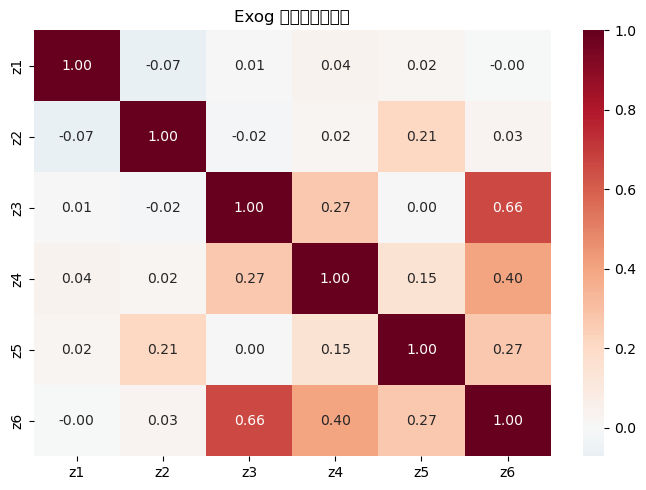


====== ACF / PACF 绘制 (dy) ======


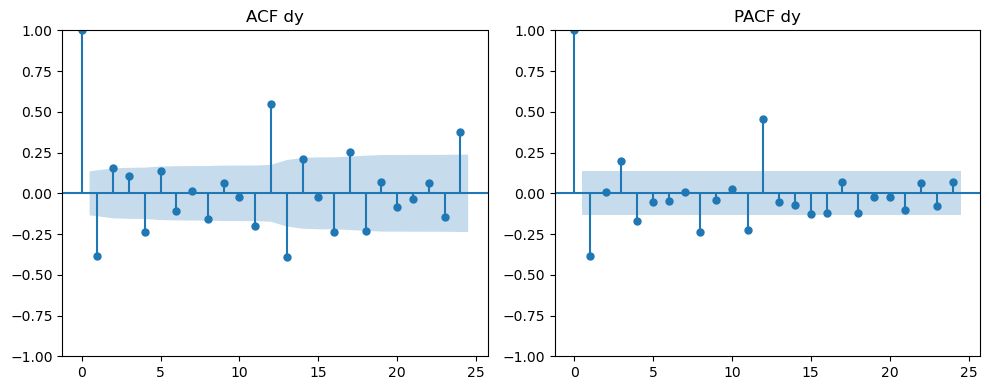


[提示] 若：
- 原始序列非平稳但差分后平稳 -> 维持 d=0 (已差分)
- 多变量高度相关或 VIF 高 -> 考虑剔除或合成指标
- 异常值数量多 -> 可在建模前做 winsor/截尾或对数转换再次检验
- 缺失月较多 -> 需先补齐再重建差分。


In [130]:
# 数据质量检查执行
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# 可选: 相关性热力图需要 seaborn，若未安装则跳过
try:
    import seaborn as sns
    HAS_SNS = True
except ImportError:
    HAS_SNS = False
    print("[警告] seaborn 未安装，跳过热力图绘制。可通过 pip install seaborn 安装。")

print("====== 基础结构信息 ======")
print("数据形状:", df.shape)
print("列名列表:", df.columns.tolist())

print("\n====== 缺失值统计 (仅显示有缺失的列) ======")
na_counts = df.isna().sum()
print(na_counts[na_counts>0] if (na_counts>0).any() else "无缺失值")

print("\n====== 日期索引检查 ======")
idx = df.index
print("索引类型:", type(idx))
print("是否单调递增:", idx.is_monotonic_increasing)
print("是否唯一:", idx.is_unique)
# 期望为严格月度频率
expected_monthly = pd.date_range(start=idx.min(), end=idx.max(), freq='MS')
missing_dates = expected_monthly.difference(idx)
print("预计月度总期数:", len(expected_monthly), "实际期数:", len(idx))
print("缺失月份数量:", len(missing_dates))
if 0 < len(missing_dates) <= 12:
    print("缺失月份示例:", missing_dates[:12])

# 重复日期数量
dup_cnt = idx.duplicated().sum()
print("重复日期数量:", dup_cnt)

print("\n====== 关键经济变量描述统计 ======")
key_cols = [c for c in ["Import Value","Export Value","General Import Charges","FEDFUNDS","MANEMP","World_import_level"] if c in df.columns]
if key_cols:
    desc = df[key_cols].describe().T
    print(desc)
else:
    print("关键列不存在于当前数据，检查列名是否匹配。")

print("\n====== 异常值(IQR 法)检测（仅计数） ======")
outlier_summary = {}
for col in key_cols:
    series = df[col].dropna()
    q1, q3 = series.quantile([0.25,0.75])
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    outliers = ((series < lower) | (series > upper)).sum()
    outlier_summary[col] = {"IQR": iqr, "lower": lower, "upper": upper, "outlier_cnt": outliers}
print(pd.DataFrame(outlier_summary).T)

print("\n====== 平稳性 (ADF) 检验 ======")
# 函数封装

def adf_report(series, name):
    s = series.dropna()
    if len(s) < 10:
        print(f"{name}: 数据长度不足，跳过 ADF。")
        return
    res = adfuller(s)
    print(f"{name}: ADF统计量={res[0]:.3f}, p值={res[1]:.4f}, 使用滞后={res[2]}, 样本量={res[3]}")
    print("临界值:", res[4])

if 'Import Value' in df.columns:
    adf_report(df['Import Value'], 'Import Value(原始)')
if 'y_level' in df.columns:
    adf_report(df['y_level'], 'y_level(log)')
if 'dy' in df.columns:
    adf_report(df['dy'], 'dy(log差分)')

print("\n====== 自变量相关矩阵 ======")
exog_cols = [c for c in ['z1','z2','z3','z4','z5','z6'] if c in df.columns]
if exog_cols:
    corr_mat = df[exog_cols].corr()
    print(corr_mat)
    if HAS_SNS:
        plt.figure(figsize=(7,5))
        sns.heatmap(corr_mat, annot=True, fmt='.2f', cmap='RdBu_r', center=0)
        plt.title('Exog 变量相关热力图')
        plt.tight_layout()
        plt.show()
else:
    print("相关变量 z1~z6 尚未全部生成或缺失。")

print("\n====== ACF / PACF 绘制 (dy) ======")
try:
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    if 'dy' in df.columns:
        dy_nonan = df['dy'].dropna()
        if len(dy_nonan) > 20:
            fig, axes = plt.subplots(1,2, figsize=(10,4))
            plot_acf(dy_nonan, ax=axes[0], lags=24)
            plot_pacf(dy_nonan, ax=axes[1], lags=24, method='ywm')
            axes[0].set_title('ACF dy')
            axes[1].set_title('PACF dy')
            plt.tight_layout(); plt.show()
        else:
            print("dy 长度不足绘制 ACF/PACF")
    else:
        print("未找到 dy 列。")
except Exception as e:
    print("绘制 ACF/PACF 失败:", e)

print("\n[提示] 若：\n- 原始序列非平稳但差分后平稳 -> 维持 d=0 (已差分)\n- 多变量高度相关或 VIF 高 -> 考虑剔除或合成指标\n- 异常值数量多 -> 可在建模前做 winsor/截尾或对数转换再次检验\n- 缺失月较多 -> 需先补齐再重建差分。")

In [131]:
data.index.duplicated

<bound method Index.duplicated of DatetimeIndex(['2008-02-01', '2008-03-01', '2008-04-01', '2008-05-01',
               '2008-06-01', '2008-07-01', '2008-08-01', '2008-09-01',
               '2008-10-01', '2008-11-01',
               ...
               '2024-11-01', '2024-12-01', '2025-01-01', '2025-02-01',
               '2025-03-01', '2025-04-01', '2025-05-01', '2025-06-01',
               '2025-07-01', '2025-08-01'],
              dtype='datetime64[ns]', name='Date', length=211, freq=None)>

# 数据质量检查概述
在进行 SARIMAX 建模前，需系统审查：

1. 结构与完整性：行列数、缺失值分布、重复日期、日期序列是否连续（月度缺口）。
2. 数值合理性：关键经济变量的描述统计、异常值（IQR 法）提示。
3. 时间序列属性：原始进口值与差分后的序列的平稳性（ADF 检验）。
4. 相关性与共线性：自变量相关矩阵与热力图，为后续 VIF 与变量筛选提供参考。
5. 自相关特征：ACF/PACF 帮助判断 AR/MA 阶数是否存在冗余或需扩展。
6. 频率与索引：确认日期频率为严格月度，若缺失提示补齐策略。

执行后的输出仅供诊断，不在此处做直接清洗修改，建议根据结果再迭代。

In [132]:
# 去掉 NA 行
cols_needed = ["dy","z1","z2","z3","z4","z6"]
data = df[cols_needed].dropna()

y = data["dy"]
X = data[["z1","z2","z3","z4","z6"]]
print("可用样本数量：", len(data))
data.head()


可用样本数量： 211


,dy,z1,z2,z3,z4,z6
Date,,,,,,
2008-02-01,-0.005831,0.000391,0.498610,2.98,26.660802,89.6
2008-03-01,0.023122,-0.001037,0.505787,2.61,25.974537,89.2
2008-04-01,0.066323,0.024208,0.516110,2.28,25.973131,89.5
2008-05-01,0.005333,0.028737,0.501405,1.98,26.709718,88.3
2008-06-01,0.031416,-0.028524,0.507812,2.00,26.128899,88.2


In [133]:
import statsmodels.api as sm

best_aic = np.inf
best_order = None
best_model = None

# y 已经是差分后的序列 → 不需要再设 d
for p in range(0,3):      # 可调范围
    for q in range(0,3):
        if p == 0 and q == 0:
            continue
        try:
            model = sm.tsa.statespace.SARIMAX(
                y, order=(p,0,q), exog=X,
                enforce_stationarity=False, enforce_invertibility=False
            ).fit(disp=False)
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = (p,0,q)
                best_model = model
        except:
            pass

print("最优 (p,d,q) =", best_order, " AIC =", best_aic)
print(best_model.summary())


c:\Users\18765\anaconda3\envs\mcm\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\18765\anaconda3\envs\mcm\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\18765\anaconda3\envs\mcm\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\18765\anaconda3\envs\mcm\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\18765\anaconda3\envs\mcm\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization faile

最优 (p,d,q) = (1, 0, 0)  AIC = -866.2980273602319
                               SARIMAX Results                                
Dep. Variable:                     dy   No. Observations:                  211
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 440.149
Date:                Mon, 24 Nov 2025   AIC                           -866.298
Time:                        02:59:42   BIC                           -842.868
Sample:                    02-01-2008   HQIC                          -856.826
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
z1            -0.0098      0.038     -0.261      0.794      -0.084       0.064
z2             3.2868      0.112     29.428      0.000       3.068       3.506
z3 

In [134]:
# 预测未来 12 个月：需要提供未来的 exog 假设
# 这里简单假设 z1~z6 未来维持最近一期水平

steps = 12
last = X.iloc[-1:]

X_future = pd.concat([last]*steps, ignore_index=True)
forecast_dy = best_model.forecast(steps=steps, exog=X_future)

forecast_dy


2025-09-01   -0.124429
2025-10-01   -0.124297
2025-11-01   -0.124298
2025-12-01   -0.124298
2026-01-01   -0.124298
2026-02-01   -0.124298
2026-03-01   -0.124298
2026-04-01   -0.124298
2026-05-01   -0.124298
2026-06-01   -0.124298
2026-07-01   -0.124298
2026-08-01   -0.124298
Freq: MS, Name: predicted_mean, dtype: float64

=== mle_retvals ===
{'fopt': -2.0860142828441512, 'gopt': array([-1.16219354e-03,  8.21489463e-03,  6.34582104e-02,  4.20670639e+00,
        5.07454452e+01,  7.47730766e-06,  1.12521370e-02]), 'fcalls': 408, 'warnflag': 2, 'converged': False, 'iterations': 1}

=== summary ===
                               SARIMAX Results                                
Dep. Variable:                     dy   No. Observations:                  211
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 440.149
Date:                Mon, 24 Nov 2025   AIC                           -866.298
Time:                        02:59:42   BIC                           -842.868
Sample:                    02-01-2008   HQIC                          -856.826
                         - 08-01-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------

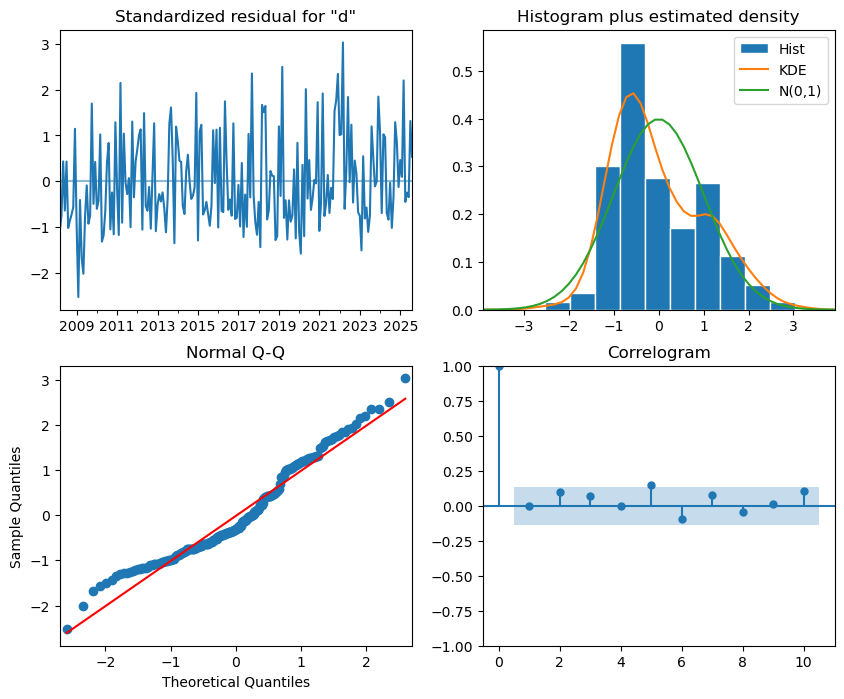

In [135]:
# 假设 best_model 是你 fit 的结果对象（SARIMAXResults）
print("=== mle_retvals ===")
print(getattr(best_model, "mle_retvals", None))

print("\n=== summary ===")
print(best_model.summary())

# 收敛标志（不同版本的 statsmodels 返回结构不一，直接打印整个 dict 最保险）
print("\nMLE 返回字典 keys:", getattr(best_model, "mle_retvals", {}).keys())

# 绘诊断图（残差、QQ、ACF）
import matplotlib.pyplot as plt
best_model.plot_diagnostics(figsize=(10,8))
plt.show()

In [136]:
# === 修正时间索引频率（解决 ValueWarning）===
# y 当前是差分后的序列；如果日期索引没有 freq，会触发 statsmodels 的 ValueWarning。
# 逻辑：
# 1. 检查原始 df 的日期是否为等间隔月度；
# 2. 若等间隔 -> 直接用 asfreq('MS') 或重新生成 date_range；
# 3. 若不等间隔 -> 重新构造完整月度索引并插值/前向填充后再计算差分。

# 备份原始 y
orig_y = y.copy()
idx = orig_y.index

import pandas as pd

# 尝试判断是否为月度：差分最常见是 1 个月 (31,30,28/29 天的混合)，我们用 to_period('M') 唯一性判断
is_monthly = False
try:
    periods = idx.to_period('M')
    is_monthly = (len(periods) == len(set(periods))) and periods.is_monotonic
except Exception:
    is_monthly = False

if is_monthly:
    # 若已经是按月一个点，但无 freq，则重建一个有 freq 的 RangeIndex
    start = idx[0]
    freq_range = pd.date_range(start=start, periods=len(idx), freq='MS')
    if (freq_range == idx).all():
        y = orig_y.copy()
        y.index = freq_range  # 赋予 freq
        print("已为 y 设置月度频率 MS。样例：", y.index[:3])
    else:
        # 日期略有偏差（可能不是每月一号），用 to_period 再转回 Timestamp
        y = pd.Series(orig_y.values,
                      index=periods.to_timestamp(how='start'))
        # 重新生成严格月初序列
        strict_range = pd.date_range(start=y.index[0], periods=len(y), freq='MS')
        y.index = strict_range
        print("日期已规范到严格月初并设置 freq=MS。样例：", y.index[:3])
else:
    # 构造完整月度序列并对缺失进行填充（这里用前向填充，你也可改成插值）
    full_range = pd.date_range(start=idx.min().replace(day=1), end=idx.max().replace(day=1), freq='MS')
    y = orig_y.reindex(full_range)
    missing = y.isna().sum()
    if missing > 0:
        y = y.ffill()  # 简单前向填充
        print(f"发现 {missing} 个缺失月，已前向填充。")
    print("构造并填充了完整的月度频率 MS。样例：", y.index[:3])

print("最终 y.index.freq:", y.index.freq)


构造并填充了完整的月度频率 MS。样例： DatetimeIndex(['2008-02-01', '2008-03-01', '2008-04-01'], dtype='datetime64[ns]', freq='MS')
最终 y.index.freq: <MonthBegin>


In [137]:
# === 标准化自变量并计算 VIF（缓解收敛问题）===
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_scaled = X.copy()
scaler = StandardScaler()
X_scaled[:] = scaler.fit_transform(X_scaled)

X_vif = sm.add_constant(X_scaled)
vif_vals = [variance_inflation_factor(X_vif.values, i) for i in range(1, X_vif.shape[1])]
VIF = pd.Series(vif_vals, index=X_vif.columns[1:]).sort_values(ascending=False)
print("VIF 指标(>10 可能存在严重共线性):\n", VIF)

# 若某些变量 VIF 很高，可选择删除后重新构造 X_scaled，例如：
# high_vif_cols = VIF[VIF>10].index
# X_scaled = X_scaled.drop(columns=high_vif_cols)


VIF 指标(>10 可能存在严重共线性):
 z6    1.984390
z3    1.810950
z4    1.189150
z2    1.009458
z1    1.006911
dtype: float64


# SARIMAX 实现评审与改进计划
问题与观察：

1. 基线模型缺失：当前跳过 (0,0,0)，导致无法判断 AR/MA 引入的 AIC 改善幅度。
2. 季节性可能未考虑：月度数据常见 12 期季节性，ADF 对差分序列平稳，但 ACF 在 12 附近的波动值得测试季节项 (P,D,Q, s=12)。
3. 频率设置顺序：修正频率的单元在首次建模之后；应在建模前确保 y.index.freq 存在，以减少警告并利于季节参数解释。
4. 标准化不一致：初步搜索使用原始 X，扩展搜索使用 X_scaled；建议统一使用标准化后的 exog，减少尺度差异对收敛影响。
5. try/except 全部吞掉：若所有拟合失败 best_model 可能为 None，应显式检测并报错。
6. 缺失值处理：z2 缺失 86 行，dropna 后样本减少；可考虑用 z2 的变化率构造或插值（后续可扩展）。
7. 预测反变换：目前仅输出 dy 的未来预测，尚未整合回未来的 log 水平与原始 Import Value。
8. 多共线性监控：相关矩阵显示 z3 与 z6 相关度 0.66，后续可在高 VIF 场景下备选剔除一个或用主成分。

改进步骤：
A. 统一：在建模前确保 y 带 freq。
B. 构造标准化 exog，建立包含 (p,q) ∈ [0,4] 的网格（含基线），并可选季节 (P,Q)∈[0,1]，季节差分 D=0（因已经一阶差分）。
C. 评价指标：AIC、BIC、残差 Ljung-Box(10)；优先：收敛 & Ljung p>0.05 & 最低 AIC；若无符合回退到最低 AIC。
D. 预测：输出 dy 预测、累计回 log 水平，再反变换得到 Import Value 预测及置信区间。
E. 健壮性：明确错误记录与失败计数，若失败率>50%，提示可能参数过大或数据问题。

将以下改进代码放在此 markdown 后。